In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

# Displacement threshold for immobile molecules
immobile_stepsize_threshold_nm = 30
# alpha component threshold for constrained diffusion
threshold_alpha = 0.7

label_1 = "mRNA, inside\nN=79,202"
label_2 = "FUS, inside\nN=232,090"
label_3 = "mRNA, outside\nN=6,690"
color_1 = "#9a3324"
color_2 = "#00274c"
color_3 = "#333232"
palette = [color_1, color_2, color_3]

postfix = "FL_FUS_in_FL_out_3in1.png"

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig2_nanodomains/FL_FUS_in_FL_out_3in1"
fname_AIO_1 = "SPT_results_AIO_concat-0Dex_noTR_0hr.csv"
fname_AIO_2 = "SPT_results_AIO_concat-20ms_FUS488_incondensate_4Reps.csv"
fname_AIO_3 = "SPT_results_AIO_concat-FL_in_1.6uM_FUS.csv"
fname_saspt_1 = "saSPT-pooled-mobile-0Dex_noTR_0hr.csv"
fname_saspt_2 = "saSPT-pooled-mobile-20ms_FUS488_incondensate_4Reps.csv"
fname_saspt_3 = "saSPT-pooled-mobile-FL_in_1.6uM_FUS.csv"

## Combine dataframes

In [2]:
os.chdir(folder_save)

df1 = pd.read_csv(fname_AIO_1)
df2 = pd.read_csv(fname_AIO_2)
df3 = pd.read_csv(fname_AIO_3)
print(label_1, df1.shape[0])
print(label_2, df2.shape[0])
print(label_3, df3.shape[0])

mRNA, inside
N=79,202 79202
FUS, inside
N=232,090 232090
mRNA, outside
N=6,690 6690


In [3]:
df1.insert(0, "label", np.repeat(label_1, df1.shape[0]))
df2.insert(0, "label", np.repeat(label_2, df2.shape[0]))
df3.insert(0, "label", np.repeat(label_3, df3.shape[0]))

# Below sequence is important for the layer order
df_AIO = pd.concat([df1, df2, df3], ignore_index=True)

In [4]:
df1 = pd.read_csv(fname_saspt_1, dtype=float)
df2 = pd.read_csv(fname_saspt_2, dtype=float)
df3 = pd.read_csv(fname_saspt_3, dtype=float)


def extract_log10D_density(df_current_file):
    range_D = df_current_file["diff_coef"].unique()
    log10D_density = []
    for log10D in range_D:
        df_current_log10D = df_current_file[df_current_file["diff_coef"] == log10D]
        log10D_density.append(df_current_log10D["mean_posterior_occupation"].sum())

    df_toplot = pd.DataFrame(
        {"log10D": np.log10(range_D), "Probability": log10D_density}, dtype=float
    )

    return df_toplot


df_saspt_1 = extract_log10D_density(df1)
df_saspt_2 = extract_log10D_density(df2)
df_saspt_3 = extract_log10D_density(df3)

df_saspt_1.insert(0, "label", np.repeat(label_1, df_saspt_1.shape[0]))
df_saspt_2.insert(0, "label", np.repeat(label_2, df_saspt_2.shape[0]))
df_saspt_3.insert(0, "label", np.repeat(label_3, df_saspt_3.shape[0]))

# Below sequence is important for the layer order
df_saspt = pd.concat([df_saspt_1, df_saspt_2, df_saspt_3], ignore_index=True)

In [5]:
df_saspt_1['log10D'].min(), df_saspt_2['log10D'].min(), df_saspt_3['log10D'].min()

(-2.0, -2.0, -2.0)

In [6]:
df_saspt_1['log10D'].max(), df_saspt_2['log10D'].max(), df_saspt_3['log10D'].max()

(2.0, 2.0, 2.0)

# Plots

### Localization error

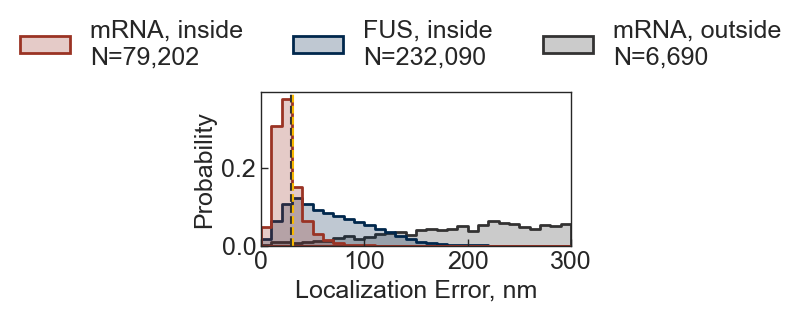

In [7]:
data = df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
data = data[data["linear_fit_R2"] > 0.7]
# quantile = np.quantile(df_AIO["linear_fit_sigma"].dropna().to_numpy(), 0.999)
plt.figure(figsize=(4, 2))
ax = sns.histplot(
    data=data,
    x="linear_fit_sigma",
    hue="label",
    palette=palette,
    bins=30,
    binrange=(0, 300),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
)
plt.axvline(immobile_stepsize_threshold_nm - 0.97, ls="--", color="#333232")
plt.axvline(immobile_stepsize_threshold_nm + 0.97, ls="--", color="#f7b801")
plt.xlim(0, 300)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=3,
    title=None,
    frameon=False,
    fontsize=18,
)
plt.xlabel("Localization Error, nm", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("1.LocError_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)

### Mean Step Size (whether static molecule)

mRNA, inside
N=79,202 60.94050617565875 0.16234996726831746
FUS, inside
N=232,090 172.90132422986855 0.23965517778005957
mRNA, outside
N=6,690 809.8420391976327 2.748358519250221


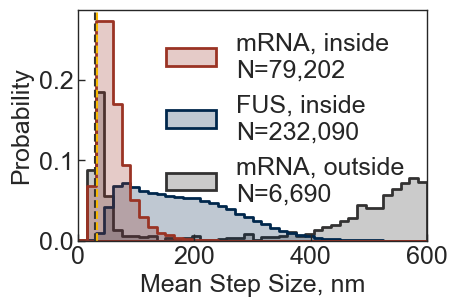

In [8]:
plt.figure(figsize=(4.5, 3))
ax = sns.histplot(
    data=df_AIO,
    x="mean_stepsize_nm",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(0, 600),
    lw=2,
    element="step",
)
plt.xlim(0, 600)
sns.move_legend(ax, 0, title=None, frameon=False, fontsize=18)
plt.axvline(immobile_stepsize_threshold_nm - 1.6, ls="--", color="#333232")
plt.axvline(immobile_stepsize_threshold_nm + 1.6, ls="--", color="#f7b801")
plt.xlabel("Mean Step Size, nm", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "2.mean_stepsize_nm_histo_" + postfix, format="png", bbox_inches="tight", dpi=300
)
print(
    label_1,
    data[data["label"] == label_1]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_1]["mean_stepsize_nm"].dropna()),
)
print(
    label_2,
    data[data["label"] == label_2]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_2]["mean_stepsize_nm"].dropna()),
)
print(
    label_3,
    data[data["label"] == label_3]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_3]["mean_stepsize_nm"].dropna()),
)

### alpha distribution

mRNA, inside
N=79,202 25888
FUS, inside
N=232,090 130120
mRNA, outside
N=6,690 5254
mRNA, inside
N=79,202 0.6132209482530656 0.001917287416700821
FUS, inside
N=232,090 0.8175583929409388 0.0010101392117753073
mRNA, outside
N=6,690 1.0230663332659893 0.005029429032031346


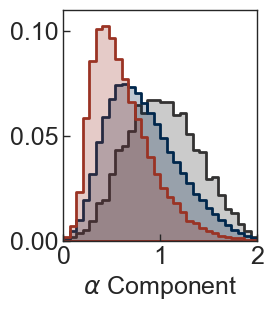

In [9]:
plt.figure(figsize=(2.5, 3))
data = df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
data = data[data["loglog_fit_R2"] > 0.7]
data = data[data["alpha"] > 0]
ax = sns.histplot(
    data=data,
    x="alpha",
    hue="label",
    palette=palette,
    bins=30,
    stat="probability",
    common_norm=False,
    binrange=(0, 2),
    lw=2,
    element="step",
    legend=False,
)
# sns.move_legend(ax, 0, title=None, frameon=False, fontsize=18)
# plt.axvline(threshold_alpha - 0.011, ls="--", color="#f7b801")
# plt.axvline(threshold_alpha + 0.011, ls="--", color="#87a878")
plt.xlim(0, 2)
plt.ylim(0, 0.11)
plt.xlabel(r"$\alpha$ Component", fontsize=18)
plt.ylabel("")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("3.alpha_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)

print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])
print(label_3, data[data["label"] == label_3].shape[0])
print(
    label_1,
    data[data["label"] == label_1]["alpha"].mean(),
    sem(data[data["label"] == label_1]["alpha"].dropna()),
)
print(
    label_2,
    data[data["label"] == label_2]["alpha"].mean(),
    sem(data[data["label"] == label_2]["alpha"].dropna()),
)
print(
    label_3,
    data[data["label"] == label_3]["alpha"].mean(),
    sem(data[data["label"] == label_3]["alpha"].dropna()),
)

### Angle Distribution

In [10]:
lst_angle = []
lst_label = []
for _, row in df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm].iterrows():
    angles = np.fromstring(
        row["list_of_angles"][1:-1],
        dtype=float,
        sep=", ",
    )
    labels = np.repeat(row["label"], angles.shape[0])
    lst_angle.extend(angles)
    lst_label.extend(labels)

data = pd.DataFrame(
    {
        "angle": np.abs(lst_angle),
        "label": lst_label,
    },
    dtype=object,
)

mRNA, inside
N=79,202 116.43854409691983 0.04769186267215627
FUS, inside
N=232,090 105.425755724358 0.04298042404224705
mRNA, outside
N=6,690 93.49089913215923 0.2702870349659614


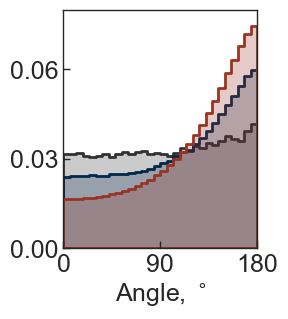

In [11]:
plt.figure(figsize=(2.5, 3.1))
bins = 30
sns.histplot(
    data=data,
    x="angle",
    hue="label",
    palette=palette,
    bins=bins,
    stat="probability",
    common_norm=False,
    binrange=(0, 180),
    lw=2,
    element="step",
    legend=False,
)
# sns.move_legend(ax, 0, title=None, frameon=False, fontsize=18)
# plt.axhline(1 / bins - 0.0004, color="#87a878", ls="--")
# plt.axhline(1 / bins + 0.0004, color="#f7b801", ls="--")
plt.xlim(0, 180)
plt.xticks([0, 90, 180])
plt.ylim(0, 0.08)
plt.yticks([0, 0.03, 0.06])
plt.xlabel("Angle, $^\circ$", fontsize=18)
plt.ylabel("")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("4.angle_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)
print(
    label_1,
    data[data["label"] == label_1]["angle"].mean(),
    sem(data[data["label"] == label_1]["angle"].dropna()),
)
print(
    label_2,
    data[data["label"] == label_2]["angle"].mean(),
    sem(data[data["label"] == label_2]["angle"].dropna()),
)
print(
    label_3,
    data[data["label"] == label_3]["angle"].mean(),
    sem(data[data["label"] == label_3]["angle"].dropna()),
)

### D distribution among the non contrained molecules

mRNA, inside
N=79,202 14571
FUS, inside
N=232,090 101215
mRNA, outside
N=6,690 4752


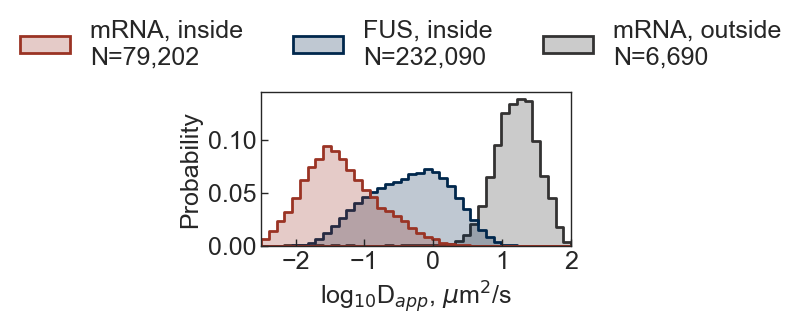

In [12]:
data = df_AIO[df_AIO["linear_fit_R2"] > 0.7]
data = data[data["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
data = data[data["alpha"] > 0.5]
plt.figure(figsize=(4, 2))
ax = sns.histplot(
    data=data,
    x="linear_fit_log10D",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(-2.5, 2),
    lw=2,
    element="step",
)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=3,
    title=None,
    frameon=False,
    fontsize=18,
)

plt.xlim(-2.5, 2)
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel(r"log$_{10}$D$_{app}$, $\mu$m$^2$/s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "5.ApparentD_linear_histo_" + postfix, format="png", bbox_inches="tight", dpi=300
)

print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])
print(label_3, data[data["label"] == label_3].shape[0])

### Plot saSPT

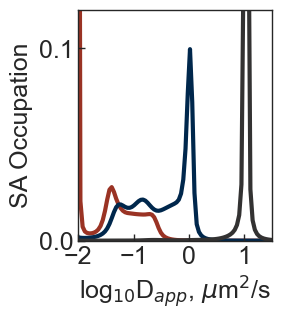

In [13]:
plt.figure(figsize=(2.5, 3))
ax = sns.lineplot(
    data=df_saspt,
    x="log10D",
    y="Probability",
    hue="label",
    palette=palette,
    lw=3,
    legend=False,
)
log10D = df_saspt["log10D"].to_numpy(dtype=float)
plt.xlim(-2, 1.5)
plt.xticks([-2, -1, 0, 1])
plt.ylim(0, 0.12)
plt.yticks([0, 0.1])
plt.xlabel(r"log$_{10}$D$_{app}$, $\mu$m$^2$/s", fontsize=18)
plt.ylabel("SA Occupation", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("6.saspt_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)

In [14]:
from scipy.signal import find_peaks


def find_major_peak(x, y):
  """
  Finds the x value corresponding to the major peak (highest value) in the y data.

  Args:
      x: A 1D NumPy array representing the x-axis values.
      y: A 1D NumPy array representing the y-axis values (curve).

  Returns:
      A tuple containing the x value and the corresponding y value of the major peak, 
      or None if no peak is found.
  """
  peaks, _ = find_peaks(y)
  # If no peaks are found, return None
  if len(peaks) == 0:
    return None

  # Find the index of the major peak (highest value in y)
  major_peak_index = peaks[np.argmax(y[peaks])]
  major_peak_x = x[major_peak_index]
  major_peak_y = y[major_peak_index]

  return major_peak_x, major_peak_y


major_peak_x, major_peak_y = find_major_peak(
    df_saspt[df_saspt["label"] == label_1]["log10D"].to_numpy(float),
    df_saspt[df_saspt["label"] == label_1]["Probability"].to_numpy(float),
)
print(label_1, 10**major_peak_x)
major_peak_x, major_peak_y = find_major_peak(
    df_saspt[df_saspt["label"] == label_2]["log10D"].to_numpy(float),
    df_saspt[df_saspt["label"] == label_2]["Probability"].to_numpy(float),
)
print(label_2, 10**major_peak_x)
major_peak_x, major_peak_y = find_major_peak(
    df_saspt[df_saspt["label"] == label_3]["log10D"].to_numpy(float),
    df_saspt[df_saspt["label"] == label_3]["Probability"].to_numpy(float),
)
print(label_3, 10**major_peak_x)

mRNA, inside
N=79,202 0.040370172585965494
FUS, inside
N=232,090 1.0476157527896652
mRNA, outside
N=6,690 10.722672220103243


### Stacked bar plot of fractions

#### Prepare plot df, calculate p vals

In [15]:
# Output file structure
labels = [label_1, label_2, label_3]
columns = [
    "label",
    "replicate_prefix",
    "N, Total",
    "N, Mobile",
    "N, Constrained",
    "Static Fraction",
    "Constrained Fraction",
]
lst_rows_of_df = []
fnames = [fname_AIO_1, fname_AIO_2, fname_AIO_3]

for i in range(3):
    df_current = pd.read_csv(fnames[i])
    df_current = df_current.astype(
        {"linear_fit_log10D": float, "mean_stepsize_nm": float, "alpha": float}
    )
    # all filenames within the current condition/file
    all_filenames = df_current["filename"].unique().tolist()
    # filename prefix for each replicate
    replicate_prefixs = np.unique([f.split("FOV")[0] for f in all_filenames])

    for prefix in replicate_prefixs:
        current_replicate_filenames = [f for f in all_filenames if prefix in f]
        df_current_replicate = df_current[
            df_current["filename"].isin(current_replicate_filenames)
        ]

        # Judege if immobile by mean step size
        df_mobile = df_current_replicate[
            df_current_replicate["mean_stepsize_nm"] >= immobile_stepsize_threshold_nm
        ]

        # Judge if constrained by alpha component
        df_constrained = df_mobile[df_mobile["alpha"] <= threshold_alpha]

        N_total = df_current_replicate.shape[0]
        N_mobile = df_mobile.shape[0]
        N_constrained = df_constrained.shape[0]

        if N_constrained < 1:
            continue

        F_immobile = (N_total - N_mobile) / N_total
        F_constrained = N_constrained / N_mobile

        # save
        lst_rows_of_df.append(
            [
                labels[i],
                prefix,
                N_total,
                N_mobile,
                N_constrained,
                F_immobile,
                F_constrained,
            ]
        )

data = pd.DataFrame.from_records(
    lst_rows_of_df,
    columns=columns,
)

In [16]:
N_total = data["N, Total"].to_numpy(int)
N_mobile = data["N, Mobile"].to_numpy(int)
N_immobile = N_total - N_mobile
N_constrained = data["N, Constrained"].to_numpy(int)
N_normal = N_mobile - N_constrained

frac_immobile = N_immobile / N_total
frac_constrained = N_constrained / N_total
frac_normal = N_normal / N_total

data["Immobile"] = frac_immobile
data["Constrained"] = frac_constrained
data["Normal"] = frac_normal

df_mean_error = pd.DataFrame(
    {
        "label": data["label"].unique(),
        "F_immobile_mean": [
            data[data["label"] == label]["Immobile"].mean()
            for label in data["label"].unique()
        ],
        "F_immobile_sem": [
            data[data["label"] == label]["Immobile"].sem()
            for label in data["label"].unique()
        ],
        "F_immobile_std": [
            data[data["label"] == label]["Immobile"].std()
            for label in data["label"].unique()
        ],
        "F_constrained_mean": [
            data[data["label"] == label]["Constrained"].mean()
            for label in data["label"].unique()
        ],
        "F_constrained_sem": [
            data[data["label"] == label]["Constrained"].sem()
            for label in data["label"].unique()
        ],
        "F_constrained_std": [
            data[data["label"] == label]["Constrained"].std()
            for label in data["label"].unique()
        ],
        "F_normal_mean": [
            data[data["label"] == label]["Normal"].mean()
            for label in data["label"].unique()
        ],
        "F_normal_sem": [
            data[data["label"] == label]["Normal"].sem()
            for label in data["label"].unique()
        ],
        "F_normal_std": [
            data[data["label"] == label]["Normal"].std()
            for label in data["label"].unique()
        ],
        "nobs": [
            data[data["label"] == label].shape[0]
            for label in data["label"].unique()
        ],  # number of observations
    },
    dtype=object,
)

In [17]:
from scipy.stats import ttest_ind_from_stats

def p_annot(p):
    """
    p-value annotation legend:
    ns: 0.05 < p <= 1
    *: 0.01 < p <= 0.05
    **: 0.001 < p <= 0.01
    ***: 0.0001 < p <= 0.001
    ****: p <= 0.0001
    """
    if p > 0.05:
        return "ns"
    elif p > 0.01:
        return "*"
    elif p > 0.001:
        return "**"
    elif p > 0.0001:
        return "***"
    else:
        return "****"


def compare2labels(label1, label2):
    print("(", label1, ") vs (", label2, "):")
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1][
            "F_normal_mean"
        ].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1]["F_normal_std"].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2][
            "F_normal_mean"
        ].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2]["F_normal_std"].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of normal fraction:", pval, p_annot(pval))
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1][
            "F_constrained_mean"
        ].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1][
            "F_constrained_std"
        ].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2][
            "F_constrained_mean"
        ].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2][
            "F_constrained_std"
        ].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of constrained fraction:", pval, p_annot(pval))
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1][
            "F_immobile_mean"
        ].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1][
            "F_immobile_std"
        ].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2][
            "F_immobile_mean"
        ].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2][
            "F_immobile_std"
        ].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of immobile fraction:", pval, p_annot(pval))

In [18]:
compare2labels(labels[0], labels[1])
compare2labels(labels[0], labels[2])
compare2labels(labels[1], labels[2])

( mRNA, inside
N=79,202 ) vs ( FUS, inside
N=232,090 ):
p value of normal fraction: 7.308481461984542e-07 ****
p value of constrained fraction: 2.963812673836001e-05 ****
p value of immobile fraction: 0.00687940133563262 **
( mRNA, inside
N=79,202 ) vs ( mRNA, outside
N=6,690 ):
p value of normal fraction: 0.0002510267469104789 ***
p value of constrained fraction: 1.0387443058214195e-07 ****
p value of immobile fraction: 0.8723238896037768 ns
( FUS, inside
N=232,090 ) vs ( mRNA, outside
N=6,690 ):
p value of normal fraction: 0.008888773691854939 **
p value of constrained fraction: 2.8628066227054593e-05 ****
p value of immobile fraction: 0.08686981974883902 ns


#### Plot

F_immobile_mean :
label: ['mRNA, inside\nN=79,202', 'FUS, inside\nN=232,090', 'mRNA, outside\nN=6,690']
fraction: [5.915485843866704 0.1654415316466639 6.438998162743878]
SEM: [1.4278867165434412 0.06289317739956925 2.778499714223587]

F_constrained_mean :
label: ['mRNA, inside\nN=79,202', 'FUS, inside\nN=232,090', 'mRNA, outside\nN=6,690']
fraction: [83.47765527821699 66.7929567190868 39.92843125194386]
SEM: [1.937139376300244 1.1463369971968769 2.167877017634813]

F_normal_mean :
label: ['mRNA, inside\nN=79,202', 'FUS, inside\nN=232,090', 'mRNA, outside\nN=6,690']
fraction: [10.606858877916315 33.041601749266526 53.63257058531226]
SEM: [1.7231340805230164 1.096952871624445 4.5217066197474995]



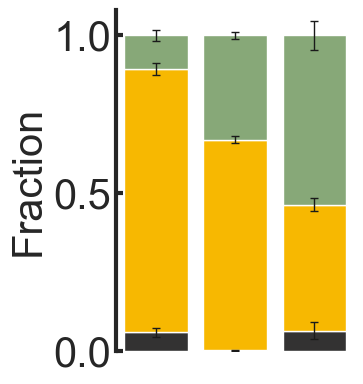

In [19]:
fig = plt.figure(figsize=(3.8, 4))
x = [1, 2, 3]
colors = [
    "#333232",
    "#f7b801",
    "#87a878",
]

df_fractions = df_mean_error[df_mean_error["label"].isin(labels)]
bottom = np.zeros(len(x))
categories = ["F_immobile_mean", "F_constrained_mean", "F_normal_mean"]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label=labels,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("label:", labels)
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]
plt.ylim(0, 1.08)
plt.ylabel("Fraction", size=30)
plt.xticks([])
plt.yticks([0, 0.5, 1])
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[["right", "top", "bottom"]].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=30,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
canvas_width = 0.5
plt.xlim(1 - canvas_width, 3 + canvas_width)
plt.xlabel("")
plt.tight_layout()
plt.savefig(
    "Fracs_compare_left_Cy5_mid_miR_right_mRNA_same20ms.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### Fitting R2 of all mobile molecules

mRNA, inside
N=79,202 73727
FUS, inside
N=232,090 231900


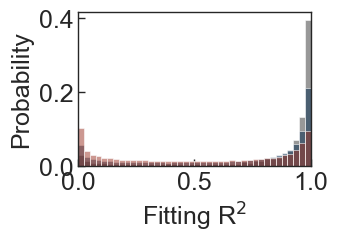

In [20]:
data = df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
plt.figure(figsize=(3, 2))
ax = sns.histplot(
    data=data,
    x="linear_fit_R2",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(0, 1),
    legend=False,
)
# sns.move_legend(ax, 0, title=None, frameon=False, fontsize=18)
plt.xlim(0, 1)
plt.xlabel(r"Fitting R$^2$", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.savefig("SM1.fitting_R2_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)

print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])